In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from importlib.resources import files
from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.utils.generate_truth import groundtruth_from_mesh

In [2]:
# Set device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
# Load dataset
# data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
# data = np.loadtxt(data_path)
# sampled_x = torch.from_numpy(data[:, :2]).float().to(device)
# sampled_y = torch.from_numpy(data[:, -1]).float().to(device)
# (m, n) = sampled_x.shape
data_path = files('manifold_gp.data').joinpath('dragon10k.stl')
nodes, faces, truth = groundtruth_from_mesh(data_path)
sampled_x = torch.from_numpy(nodes).float().to(device)
sampled_y = torch.from_numpy(truth).float().to(device)
(m, n) = sampled_x.shape

In [4]:
# Set Train Indices
num_train = 50
train_idx = torch.randperm(m)[:num_train]

In [5]:
# Set Test Indices
num_test = 10
test_idx = torch.randperm(m)[:num_test]

In [6]:
%%capture
# Noise Grid
min_noise_scale = 0
max_noise_scale = 0.1
resolution = 4
manifold_noise, function_noise = torch.meshgrid(torch.linspace(min_noise_scale, max_noise_scale, steps=resolution),
                                                torch.linspace(min_noise_scale, max_noise_scale, steps=resolution))

In [7]:
# Record Loss & MSE
count = 1
loss = torch.zeros_like(manifold_noise)
mse = torch.zeros_like(manifold_noise)

In [8]:
# Create Kernel
nu = 3
neighbors = 10
modes = 100
kernel = gpytorch.kernels.ScaleKernel(RiemannMaternKernel(nu=nu, nodes=sampled_x, neighbors=neighbors, modes=modes))

In [9]:
# Define Optimization Parameters
lr = 1e-1
iters = 100
verbose = False

In [10]:
%%capture
# Model Hyperparameters
hypers = {
    'likelihood.noise_covar.noise': 1e-5,
    'covar_module.base_kernel.epsilon': 0.5027,
    'covar_module.base_kernel.lengthscale': 0.5054,
    'covar_module.outputscale': 1.0,
}

In [11]:
for i in range(resolution):
    for j in range(resolution):
        print(
            f"Iteration: {count}/{resolution**2}, Manifold Noise: {manifold_noise[i,j]}, Function Noise: {function_noise[i,j]}")
        # Add noise to samples
        noisy_x = sampled_x + \
            manifold_noise[i, j] * torch.randn(m, n).to(device)
        noisy_y = sampled_y + function_noise[i, j] * torch.randn(m).to(device)

        # Train dataset
        train_x = noisy_x[train_idx, :]
        train_y = noisy_y[train_idx]

        # Test dataset
        test_x = noisy_x[test_idx, :]
        test_y = noisy_y[test_idx]

        # Update Kernel
        if hasattr(kernel, 'base_kernel'):
            kernel.base_kernel.nodes = noisy_x
            kernel.base_kernel.generate_graph()
        else:
            kernel.nodes = noisy_x
            kernel.generate_graph()

        # Create model
        likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8))
        model = RiemannGP(noisy_x, noisy_y, likelihood, kernel).to(device)

        # Init hyperparameters and train the model
        model.initialize(**hypers)
        loss[i, j] = model.manifold_informed_train(lr, iters, verbose)

        # Evaluate the model
        likelihood.eval()
        model.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = likelihood(model(noisy_x))
            mse[i, j] = torch.linalg.norm(sampled_y - preds.mean)/sampled_y.shape[0]

        count += 1

Iteration: 1/16, Manifold Noise: 0.0, Function Noise: 0.0


/home/bernardo/.local/lib/python3.10/site-packages/manifold_gp/kernels/riemann_kernel.py:116: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  self.eigenvalues = torch.from_numpy(T).float().to(self.nodes.device)
/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Iteration: 2/16, Manifold Noise: 0.0, Function Noise: 0.01666666753590107
Iteration: 3/16, Manifold Noise: 0.0, Function Noise: 0.03333333134651184
Iteration: 4/16, Manifold Noise: 0.0, Function Noise: 0.05000000074505806
Iteration: 5/16, Manifold Noise: 0.01666666753590107, Function Noise: 0.0
Iteration: 6/16, Manifold Noise: 0.01666666753590107, Function Noise: 0.01666666753590107
Iteration: 7/16, Manifold Noise: 0.01666666753590107, Function Noise: 0.03333333134651184
Iteration: 8/16, Manifold Noise: 0.01666666753590107, Function Noise: 0.05000000074505806
Iteration: 9/16, Manifold Noise: 0.03333333134651184, Function Noise: 0.0
Iteration: 10/16, Manifold Noise: 0.03333333134651184, Function Noise: 0.01666666753590107
Iteration: 11/16, Manifold Noise: 0.03333333134651184, Function Noise: 0.03333333134651184
Iteration: 12/16, Manifold Noise: 0.03333333134651184, Function Noise: 0.05000000074505806
Iteration: 13/16, Manifold Noise: 0.05000000074505806, Function Noise: 0.0
Iteration: 1

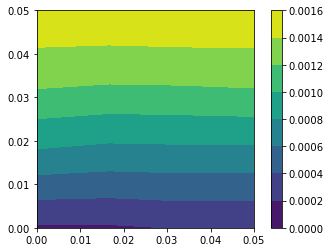

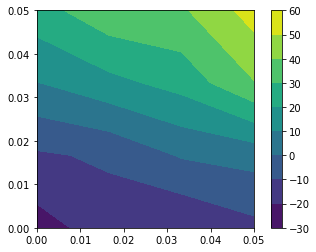

In [15]:
with torch.no_grad():
#     fig = plt.figure(figsize=(17, 6))
#     ax = fig.add_subplot(121)
#     contour_mse = ax.contourf(function_noise, manifold_noise, mse)
#     ax.axis('square')
#     fig.colorbar(contour_mse)

#     ax = fig.add_subplot(122)
#     contour_loss = ax.contourf(function_noise, manifold_noise, loss)
#     ax.axis('square')
#     fig.colorbar(contour_loss)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    contour_mse = ax.contourf(function_noise, manifold_noise, mse)
    ax.axis('square')
    fig.colorbar(contour_mse)
    fig.savefig('mse_grid.png')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    contour_loss = ax.contourf(function_noise, manifold_noise, loss)
    ax.axis('square')
    fig.colorbar(contour_loss)
    fig.savefig('loss_grid.png')